In [1]:

from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
from collections import defaultdict
from scipy.stats import pareto, gamma
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from scipy.spatial.distance import cdist
import numpy as np

from datetime import date

filename = "moonz_weds.csv"

# read the data
data = pd.read_csv(filename, skipinitialspace=True)
data.columns = data.columns.str.strip()

# Display first few rows to check structure
print(data.head())
print(data.columns)

                 Track ID              Track Name  \
0  1TCRCDezEMaQ60yIO8Me6F               Dana dana   
1  0tgVpDi06FyKpA1z0VMD4v                 Perfect   
2  7wKUqlOL9OES7gwPdgUcQl   رايحين نسهر - بام بام   
3  1bxP4M9ICllcg7mel8kH89                   Reine   
4  0pwYLVXVknPSGUQb39cePC  As Long As You Love Me   

                        Album Name          Artist Name(s) Release Date  \
0  L'anthologie du Raï (50 titres)              Cheb Rayan   2016-01-29   
1                       ÷ (Deluxe)              Ed Sheeran   2017-03-03   
2    رايحين نسهر - بام بام - سينجل         Mohamed Ramadan   2019-01-01   
3                    Gentleman 2.0                   Dadju   2017-11-24   
4         Believe (Deluxe Edition)  Justin Bieber,Big Sean   2012-06-15   

   Duration (ms)  Popularity                   Added By              Added At  \
0         232333           0  myo20ysxpfrjcs3hesgkcs93f  2024-10-30T00:20:04Z   
1         263400          85  myo20ysxpfrjcs3hesgkcs93f  2024-10-29T

In [2]:
#features = data[['Loudness', 'Liveness','Tempo', 'Valence',  'Danceability', 'Energy', 'Key']].dropna()
features = data[['Loudness', 'Liveness']].dropna()


In [3]:

# Standardize features
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)


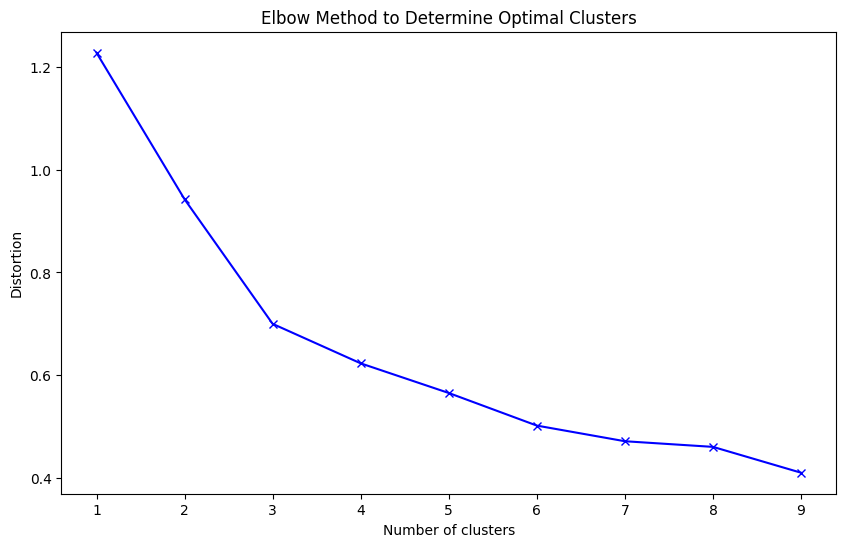

In [4]:
# Elbow method to find optimal number of clusters
distortions = []
K = range(1, 10)
for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(features_scaled)
    distortions.append(sum(np.min(cdist(features_scaled, kmeans.cluster_centers_, 'euclidean'), axis=1)) / features_scaled.shape[0])

# Plotting the Elbow curve
plt.figure(figsize=(10, 6))
plt.plot(K, distortions, 'bx-')
plt.xlabel('Number of clusters')
plt.ylabel('Distortion')
plt.title('Elbow Method to Determine Optimal Clusters')
plt.show()


In [5]:
# Clustering with the chosen number of clusters (adjust 'n_clusters' based on elbow method)
optimal_clusters = 3  # Replace with your elbow result
kmeans = KMeans(n_clusters=optimal_clusters, random_state=42)
data['Cluster'] = kmeans.fit_predict(features_scaled)

# Inspect the first few rows with cluster labels
print(data[['Track Name', 'Artist Name(s)', 'Tempo', 'Valence', 'Danceability', 'Energy', 'Key', 'Cluster']].head())


               Track Name          Artist Name(s)    Tempo  Valence  \
0               Dana dana              Cheb Rayan  105.807    0.913   
1                 Perfect              Ed Sheeran   95.050    0.168   
2   رايحين نسهر - بام بام         Mohamed Ramadan  160.024    0.929   
3                   Reine                   Dadju   98.174    0.704   
4  As Long As You Love Me  Justin Bieber,Big Sean  139.691    0.613   

   Danceability  Energy  Key  Cluster  
0         0.741   0.835    0        1  
1         0.599   0.448    8        0  
2         0.720   0.997    2        0  
3         0.399   0.395    2        1  
4         0.571   0.873    0        2  


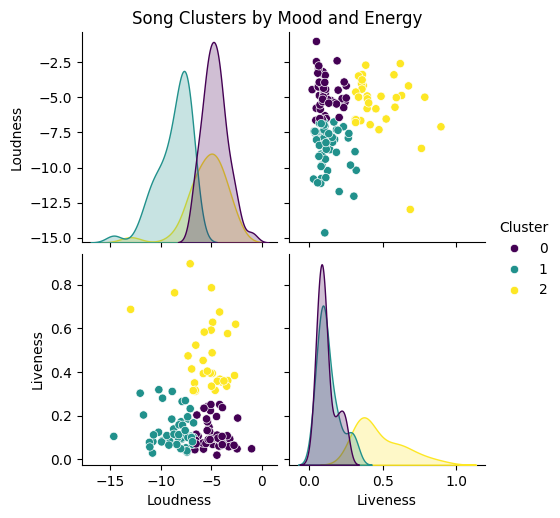

In [7]:
# Pairplot to visualize clusters
# sns.pairplot(data[['Loudness', 'Danceability', 'Energy', 'Cluster']], hue='Cluster', palette='viridis')
sns.pairplot(data[['Loudness', 'Liveness', 'Cluster']], hue='Cluster', palette='viridis')

plt.suptitle("Song Clusters by Mood and Energy", y=1.02)
plt.show()


In [20]:
def suggest_next_song(current_track_id):
    # Find current track's cluster
    current_song = data[data['Track ID'] == current_track_id]
    if current_song.empty:
        return "Track ID not found."
    
    cluster = current_song['Cluster'].values[0]
    # Find other songs in the same cluster, excluding the current song
    similar_songs = data[(data['Cluster'] == cluster) & (data['Track ID'] != current_track_id)]
    
    # Sort by tempo, valence, or any metric you choose for smooth transitions
    similar_songs = similar_songs.sort_values(by='Tempo', ascending=False)
    
    # Return a suggestion
    return similar_songs[['Track Name', 'Artist Name(s)', 'Tempo', 'Valence', 'Danceability']].head(5)

# Example of getting next song suggestion
suggested_songs = suggest_next_song("00Mb3DuaIH1kjrwOku9CGU")
print("Suggested next songs for smooth transition:")
print(suggested_songs)


Suggested next songs for smooth transition:
                Track Name          Artist Name(s)    Tempo  Valence  \
13               Shou Bado                    Yara  150.026    0.755   
4   As Long As You Love Me  Justin Bieber,Big Sean  139.691    0.613   
78    Heta L9it Li Tebgini       Rachid Kasmi,ZIKO  132.016    0.799   
62      You Belong With Me            Taylor Swift  129.966    0.435   
81            C'est La Vie                  Khaled  129.952    0.806   

    Danceability  
13         0.655  
4          0.571  
78         0.771  
62         0.687  
81         0.616  


In [22]:
# This one generate the playlist 
def generate_playlist(data, tempo_weight=1.0, valence_weight=1.5, switch_threshold=10):
    # Copy to prevent modification of the original data
    playlist_data = data.copy()
    playlist_order = []
    
    current_song = playlist_data.iloc[0]
    playlist_order.append(current_song['Track ID'])

    while len(playlist_order) < len(playlist_data):
        current_cluster = current_song['Cluster']
        potential_songs = playlist_data[(playlist_data['Cluster'] == current_cluster) & 
                                        (~playlist_data['Track ID'].isin(playlist_order))]

        # Early switch if no nearby song in the same cluster
        if potential_songs.empty or all(
            (abs(potential_songs['Tempo'] - current_song['Tempo']) +
             abs(potential_songs['Valence'] - current_song['Valence']) > switch_threshold)):
            potential_songs = playlist_data[~playlist_data['Track ID'].isin(playlist_order)]
        
        # Calculate weighted distance
        potential_songs = potential_songs.copy()
        potential_songs['distance'] = (
            tempo_weight * (potential_songs['Tempo'] - current_song['Tempo']).abs() +
            valence_weight * (potential_songs['Valence'] - current_song['Valence']).abs() +
            (potential_songs['Liveness'] - current_song['Liveness']).abs() +
            (potential_songs['Danceability'] - current_song['Danceability']).abs()  + 
            (potential_songs['Energy'] - current_song['Energy']).abs()
        )
        
        next_song = potential_songs.sort_values(by='distance').iloc[0]
        
        playlist_order.append(next_song['Track ID'])
        current_song = next_song

    return playlist_order

# Generate the playlist order
playlist_order = generate_playlist(data)

# Reorder the DataFrame based on the playlist_order and keep 'Track ID' as a column
ordered_playlist = data.loc[data['Track ID'].isin(playlist_order)]
ordered_playlist = ordered_playlist.set_index('Track ID').loc[playlist_order].reset_index()

# Save the ordered playlist to a CSV file
output_filename = "output3.csv"
ordered_playlist.to_csv(output_filename, index=False)